# Importing all the required modules

In [1]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint, CSVLogger
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy as logloss
from tensorflow.keras.metrics import categorical_accuracy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from PIL import Image
import scipy
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import json



2024-09-10 07:08:27.523858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 07:08:27.523960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 07:08:27.700349: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading the dataset

In [2]:
base_path = '/kaggle/input/deepfake-dataset-merged/'

def plot_img(base_path, set_):
    dir_ = os.path.join(base_path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

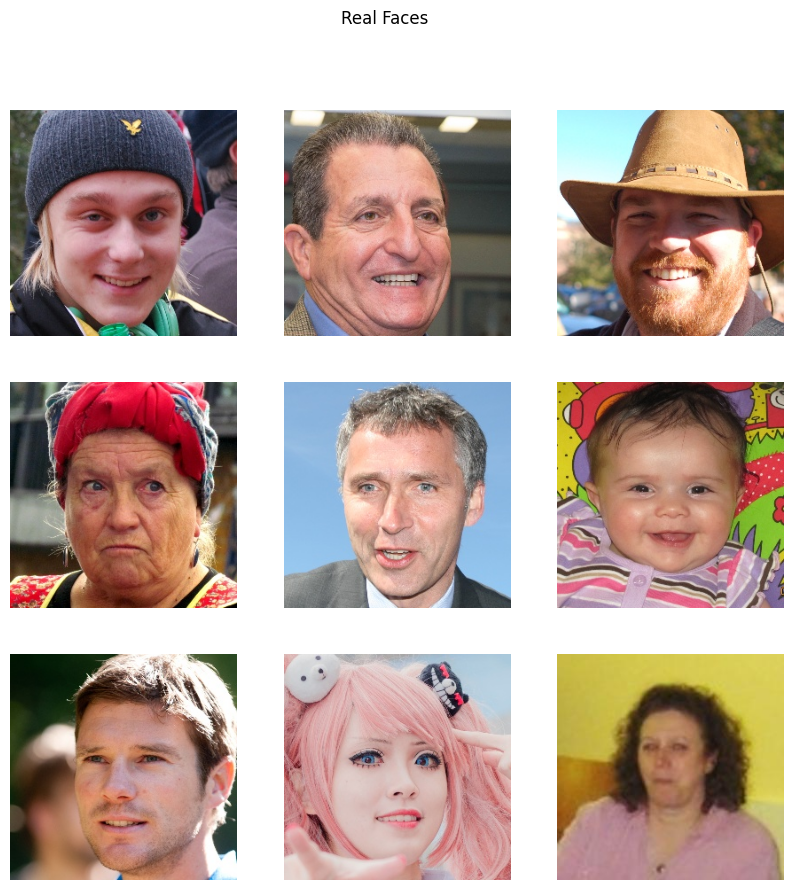

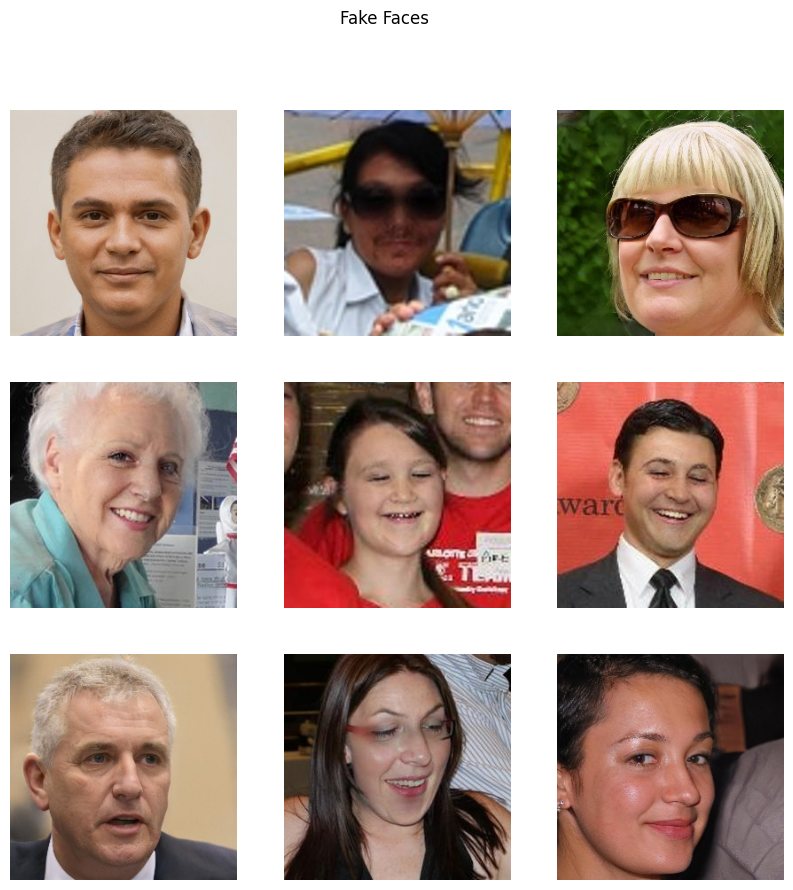

In [3]:
plot_img(base_path, 'Real').show()
plot_img(base_path, 'Fake').show()

# Preprocessing the data

In [4]:
ig = ImageDataGenerator(rescale=1./255.)
train_flow = ig.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

ig1 = ImageDataGenerator(rescale=1./255.)

valid_flow = ig1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_flow = ig.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle = False,
    class_mode='categorical'
)

train_flow.class_indices

Found 248002 images belonging to 2 classes.
Found 60428 images belonging to 2 classes.
Found 31905 images belonging to 2 classes.


{'Fake': 0, 'Real': 1}

# Building the model

In [5]:

def build_model():
    inputs=Input(shape=(224, 224, 3))
    densenet = ResNet50(
                        weights='imagenet',
                        include_top=False,
                        input_tensor=inputs
                        )
    model = Sequential([inputs,
                        densenet,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(1024,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(512,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(2, activation='softmax')
                        ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )
    return model

In [6]:
model=build_model()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,217,858 (100.01 MB)

 Trainable params: 26,161,666 (99.80 MB)

 Non-trainable params: 56,192 (219.50 KB)

# Specifying model parameters

In [7]:
checkpoint = ModelCheckpoint(filepath='model.weights.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss',
                             save_weights_only=True
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
callbacks = [checkpoint, reduce_lr, csv_logger,es]

# Training the model 

In [8]:
train_steps = 100000//64
valid_steps = 20000//64

history = model.fit(train_flow,
    epochs = 50,
    steps_per_epoch =train_steps,
    validation_data =valid_flow,
    validation_steps = valid_steps,
    callbacks=callbacks
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725952393.367961      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1725952393.463933      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.7921 - loss: 0.4520

W0000 00:00:1725953197.979335      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.44812, saving model to model.weights.h5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 999s 583ms/step - accuracy: 0.7921 - loss: 0.4519 - val_accuracy: 0.8523 - val_loss: 0.4481 - learning_rate: 0.0010
Epoch 2/50
1236/1562 ━━━━━━━━━━━━━━━━━━━━ 2:54 536ms/step - accuracy: 0.9409 - loss: 0.1495

W0000 00:00:1725953965.742333      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9381 - loss: 0.1555
Epoch 2: val_loss did not improve from 0.44812
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 922s 591ms/step - accuracy: 0.9381 - loss: 0.1555 - val_accuracy: 0.7005 - val_loss: 2.0370 - learning_rate: 0.0010
Epoch 3/50
 752/1562 ━━━━━━━━━━━━━━━━━━━━ 6:57 515ms/step - accuracy: 0.8848 - loss: 0.2731

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 3: val_loss improved from 0.44812 to 0.37121, saving model to model.weights.h5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 467s 299ms/step - accuracy: 0.8954 - loss: 0.2509 - val_accuracy: 0.8374 - val_loss: 0.3712 - learning_rate: 0.0010
Epoch 4/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9436 - loss: 0.1419
Epoch 4: val_loss improved from 0.37121 to 0.31364, saving model to model.weights.h5


W0000 00:00:1725955510.586738      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 819s 520ms/step - accuracy: 0.9436 - loss: 0.1419 - val_accuracy: 0.8607 - val_loss: 0.3136 - learning_rate: 0.0010
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9613 - loss: 0.1011
Epoch 5: val_loss did not improve from 0.31364
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 889s 569ms/step - accuracy: 0.9613 - loss: 0.1011 - val_accuracy: 0.8274 - val_loss: 0.5371 - learning_rate: 0.0010
Epoch 6/50
 752/1562 ━━━━━━━━━━━━━━━━━━━━ 6:57 516ms/step - accuracy: 0.9693 - loss: 0.0823
Epoch 6: val_loss did not improve from 0.31364
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 464s 297ms/step - accuracy: 0.9696 - loss: 0.0812 - val_accuracy: 0.8517 - val_loss: 0.3605 - learning_rate: 0.0010
Epoch 7/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9697 - loss: 0.0791
Epoch 7: val_loss improved from 0.31364 to 0.17916, saving model to model.weights.h5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 884s 565ms/step - accuracy: 0.9697 - loss: 0.0791 - val_accuracy: 0.9310 - va

# Plotting Accuracy and Loss

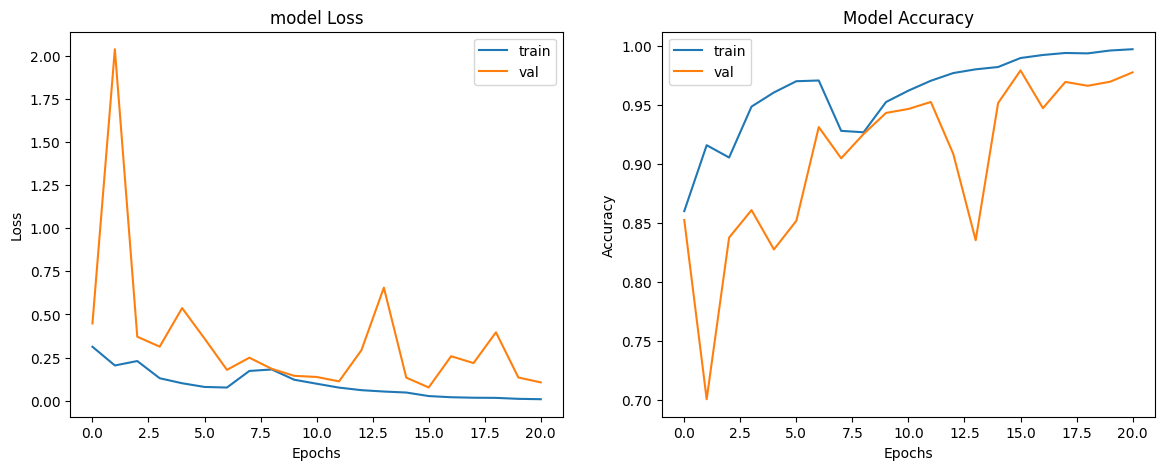

In [9]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [10]:
y_pred = model.predict(test_flow)

y_test = test_flow.classes

y_pred_labels = np.argmax(y_pred, axis=1)

31905/31905 ━━━━━━━━━━━━━━━━━━━━ 269s 8ms/step


# Confusion matrix

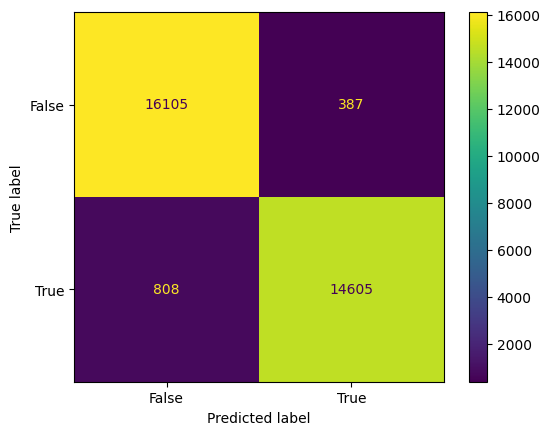

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix=confusion_matrix(y_test, y_pred_labels)
confusion_matrix

Fake=False
Real=True
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [Fake, Real])

cm_display.plot()
plt.show()

In [12]:
from sklearn import metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_labels))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_labels))
print()
print(metrics.classification_report(y_test, y_pred_labels))
_, accu = model.evaluate(test_flow)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

ROC AUC Score: 0.9620553990390761
AP Score: 0.9484413800764177

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     16492
           1       0.97      0.95      0.96     15413

    accuracy                           0.96     31905
   macro avg       0.96      0.96      0.96     31905
weighted avg       0.96      0.96      0.96     31905

31905/31905 ━━━━━━━━━━━━━━━━━━━━ 285s 9ms/step - accuracy: 0.9819 - loss: 0.1218
Final Test Acccuracy = 96.255


# Testing for a random image

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "resnet50" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 128, 128, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 128, 128, 3), dtype=float32)
  • training=False
  • mask=None

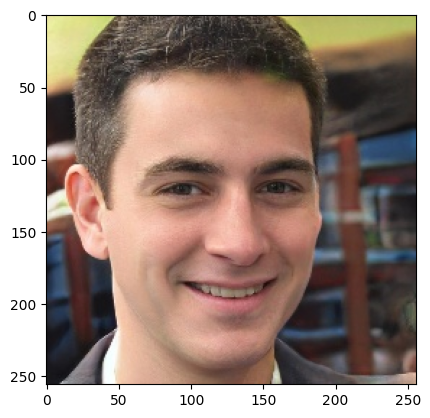

In [13]:
import PIL
from PIL import Image
im1 = Image.open('/kaggle/input/deepfake-dataset-merged/valid/Fake/03W1TOXADG.jpg')
im2=im1.resize((128,128))
p1 = np.array(im2)
p1=p1/255
plt.imshow(im1)
p1 = np.expand_dims(p1, axis=0)
p1.shape

op=np.argmax(model.predict(p1),axis=-1)
print(op)
if op== [0]:
    print('Fake Face')
else:
    print("Real Face")